In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt
from matplotlib import image
from skimage.transform import resize
import os
import gc

Vamos a tratar de visualizar que es lo que "aprende" mi modelo\
CatsvDogs entrenado en el ejercicio 1 (CNN). Vamos a visualizar\
activaciones, filtros y hacer gradient ascend

Imagenes de prueba: 10


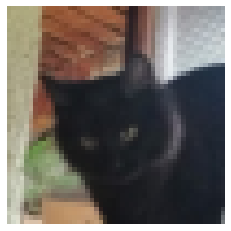

In [2]:
folder = 'c:\\Users\\Lautaro\\Desktop\\Lautaro\\asd\\2021\\Doctorado\\Materias\\Deep Learning (2020)\\Practicas\\Mias\\P4\\img'
images = []
images_res = []

for img in os.listdir(folder):
    path = os.path.join(folder, img)
    curr_img = image.imread(path)
    images.append(curr_img)
    images_res.append(resize(curr_img, (50, 50), anti_aliasing=1))


print('Imagenes de prueba:', len(images))
plt.imshow(images_res[3])
plt.axis('off');

In [3]:
X_test = np.stack(images_res, axis=0)
print(X_test.shape, X_test.max())

(10, 50, 50, 3) 0.989100054871319


In [4]:
base_model = keras.models.load_model('CatsvDogs.h5')
base_model.summary()

Model: "MyNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 47, 47, 32)        1568      
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 32)        16416     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 21, 21, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                         

In [5]:
layer_name = 'conv2d'
layer = base_model.get_layer(layer_name)
activation = layer.output
activation

<KerasTensor: shape=(None, 47, 47, 32) dtype=float32 (created by layer 'conv2d')>

In [6]:
run = keras.backend.function([base_model.input], [activation])
imgs = run([X_test])[0]

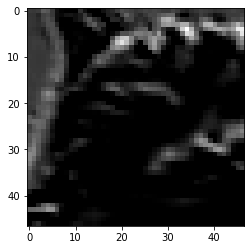

In [7]:
plt.figure
plt.imshow(np.squeeze(imgs[1,...,1]), 'gray')

Como son los filtros?

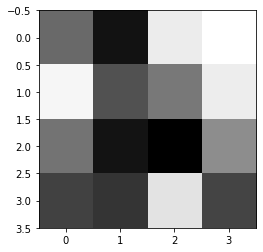

In [8]:
w = layer.get_weights()[0]
plt.figure()
plt.imshow(w[...,0,2], 'gray')
#mmm no me dicen mucho

Lo mejor: Gradient ascendent input space\
Copiado de France y sacado de:\
https://keras.io/examples/vision/visualizing_what_convnets_learn/

In [75]:
#Codigo totalmente copiado de france

def compute_loss(input_image, filter_index,feature_extractor):
    activation = feature_extractor(input_image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

# Funcion que realiza un paso del gradient ascent
@tf.function
def gradient_ascent_step(img, filter_index, lr,feature_extractor):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index,feature_extractor)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += lr * grads
    return loss, img

# Funcion para desnormalizar
def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15
    # Center crop
    #img = img[25:-25, 25:-25, :]
    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)
    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

# funcion para inicializar una imagen en gris
def initialize_image():
    img = tf.random.uniform((1, 50, 50, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return img * 0.25

# 
def visualize_filter(filter_index,feature_extractor):
    img = initialize_image()
    for iteration in range(300):
        loss, img = gradient_ascent_step(img, filter_index, .1, feature_extractor)
    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img
    

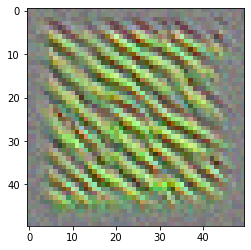

In [80]:
layer_name = 'conv2d_1'
layer = base_model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=base_model.inputs, outputs=layer.output)

loss, img = visualize_filter(11, feature_extractor)
plt.imshow(img)